<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#The-Kalman-filter" data-toc-modified-id="The-Kalman-filter-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>The Kalman filter</a></span><ul class="toc-item"><li><span><a href="#Example-of-aplication:-system-identification" data-toc-modified-id="Example-of-aplication:-system-identification-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Example of aplication: system identification</a></span></li><li><span><a href="#Example-of-aplication:-channel-equalization" data-toc-modified-id="Example-of-aplication:-channel-equalization-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Example of aplication: channel equalization</a></span></li></ul></li><li><span><a href="#Time-varying-systems" data-toc-modified-id="Time-varying-systems-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Time-varying systems</a></span></li></ul></div>

In [1]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b master https://github.com/edsonportosilva/adaptive-signal-processing
    from os import chdir as cd
    cd('/content/notebooks/')
    ! pip install -e .
    ! pip install SciencePlots

import sympy as sp
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from IPython.core.display import HTML
from IPython.display import Image
try:
    import scienceplots
except:
    ! pip install SciencePlots
    
from utils import set_preferences, genConvGIF, symdisp, round_expr

plt.style.use(['science','ieee'])
set_preferences()

plt.rcParams['figure.figsize'] = [5, 2.5]
plt.rcParams['figure.dpi'] = 150

saveFigures = False
figurePath = 'G:\\Meu Drive\\DEE UFCG\\Disciplinas e ementas\\TEEE - Processamento adaptativo de sinais\\lecture notes\\figures\\'

In [4]:
from algorithms import estimate_correlation_matrix, estimate_cross_correlation, lms, nlms, lms_newton

# Kalman filter algorithms


## The Kalman filter

In [185]:
#@njit
def kalman_filter(A, H, Q, R, x_init, P_init, y):
    """
    Run a Kalman filter on a series of observations for a system without external inputs.
    
    Parameters:
    - A: State transition matrix.
    - H: Observation matrix.
    - Q: Process noise covariance matrix.
    - R: Measurement noise covariance matrix.
    - x_init: Initial state estimate.
    - P_init: Initial covariance estimate.
    - y: array of observations (measurement vectors).

    Returns:
    - x_estimates: List of state estimates after each observation.
    - P_estimates: List of covariance estimates after each observation.
    """
    # Initialize state and covariance
    x = x_init
    P = x_init*x_init.T
        
    try:
        if y.shape[0] > y.shape[1]:
            y = y.T
    except IndexError:
        y = y.reshape(1,len(y))
    
    x_estimates = np.zeros((x_init.shape[0], y.shape[1]))
    
    for ind in range(y.shape[1]):
        y_ = y[:,ind].reshape(-1,1)
                
        # Prediction step
        x_pred = A @ x   
        P_pred = A @ P @ A.T + Q     
               
        # Kalman gain                        
        K = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + R)
        
        # Update step
        x = x_pred + K @ (y_ - H @ x_pred)
        P = (np.eye(P.shape[0]) - K @ H) @ P_pred
                
        # Store estimates
        x_estimates[:,ind] = x.flatten()

    return x_estimates


In [186]:
import numpy as np

def simulate_mass_spring(dt, total_time, x_init, k, m, σ2):
    """
    Simulate an ideal mass-spring system over time using a state-space model.
    
    Parameters:
    - dt: Time step for the simulation.
    - total_time: Total simulation time.
    - x_init: Initial state vector [position, velocity].
    - k: Spring constant.
    - m: Mass of the object.
    
    Returns:
    - positions: Array of positions over time.
    - velocities: Array of velocities over time.
    """
    # Define the state transition matrix for the mass-spring system
    A = np.array([[0, 1],
                  [-k / m, 0]])
    
    # Discretize A for time step dt (using an approximation)
    A_d = np.eye(2) + A * dt
    
    # Initialize state and lists to store the results
    x = np.array(x_init).reshape(-1, 1)
    
    # Number of steps
    num_steps = int(total_time / dt)
    states = np.zeros((x.shape[0], num_steps))
    states = np.zeros((x.shape[0], num_steps))
    
    for ind in range(num_steps):
        # Update the state using the discretized state-space model
        x = A_d @ x + np.random.normal(0, np.sqrt(σ2), x.shape[1])
        states[:,ind] = x.flatten()
    
    return states, A_d

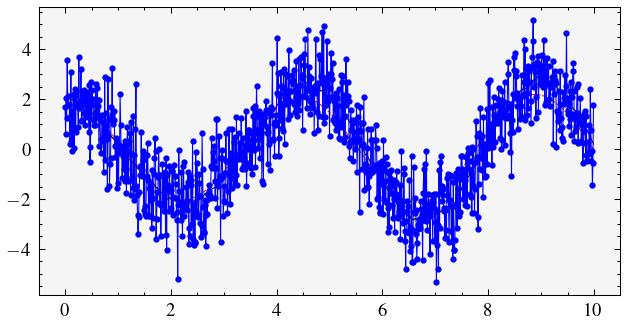

In [214]:
# Define parameters
dt = 0.01              # Time step in seconds
total_time = 10.0      # Total simulation time in seconds
x_init = np.array([[2.0], [0]])    # Initial position (1 meter) and initial velocity (0 m/s)
k = 2.0                # Spring constant (N/m)
m = 1.0                # Mass (kg)

# process noise
σ2_n = 0.0005

# measurement noise
x_var = 1
dxdt_var = 0.025

# Simulate the mass-spring system
x, A = simulate_mass_spring(dt, total_time, x_init, k, m, σ2_n)
x_noiseLess, A = simulate_mass_spring(dt, total_time, x_init, k, m, 0)

x_meas = x + np.random.normal(0, np.sqrt(x_var), x.shape[1])
t = np.arange(0, total_time, dt)

plt.plot(t, x[0])
plt.plot(t, x_noiseLess[0])
plt.plot(t, x_meas[0],'-o')

#plt.plot(t, dxdt)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

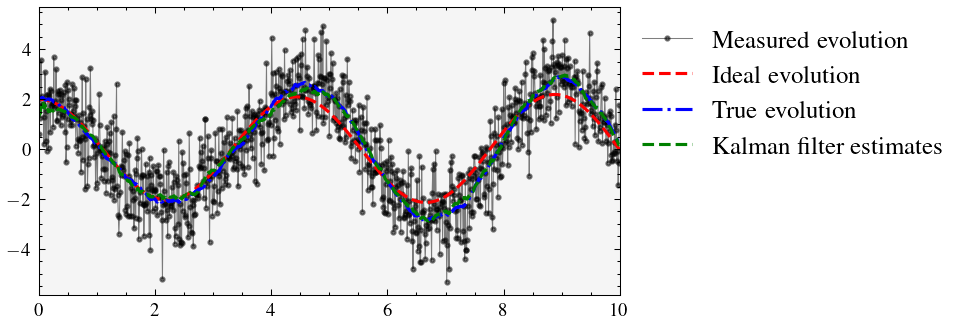

In [220]:
H = np.array([[1, 0]])
symdisp('H =', sp.Matrix(H))

Q = σ2_n*np.eye(x_init.shape[0])
symdisp('Q =', sp.Matrix(Q))

P_init = x_init@x_init.T
symdisp('P =', sp.Matrix(P_init))

R = x_var #* np.eye(len(x_init))
#symdisp('R =', sp.Matrix(R))

x_kalman = kalman_filter(A, H, Q, R, x_init, P_init, x_meas[0,:])

plt.plot(t, x_meas[0],'-o',alpha=0.5, label='Measured evolution')
plt.plot(t, x_noiseLess[0],'--', linewidth=1.5,label='Ideal evolution')
plt.plot(t, x[0],'-.', linewidth=1.5, label='True evolution')
plt.plot(t, x_kalman[0,:],'--',linewidth=1.5,label='Kalman filter estimates')
plt.xlim(0,10)
plt.legend(bbox_to_anchor=(1, 1));